In [1]:
from pathlib import Path

In [2]:
import json
import glob

In [3]:
configs = []

for path in glob.glob(str(Path("output") / "state_*_config.json")):
    path = Path(path)

    with Path(path).open("r") as config:
        configs.append(json.load(config))

In [4]:
import numpy as np

In [5]:
def load_model_run(base_path: Path, ensemble_member: int, k: int = 36) -> np.ndarray:
    file_path = base_path.with_name(f"{base_path.name}_{ensemble_member}")

    return np.fromfile(file_path, dtype=np.double).reshape(-1, k)

In [6]:
def load_model_ensemble(base_path: Path, ensemble_size: int = 11, k: int = 36) -> np.ndarray:
    return np.stack([load_model_run(base_path, i, k=k) for i in range(ensemble_size)])

In [7]:
def ensemble_mean(ensemble: np.ndarray) -> np.ndarray:
    return np.mean(ensemble, axis=0)

In [8]:
def ensemble_spread(ensemble: np.ndarray) -> np.ndarray:
    return np.std(ensemble, axis=0)

In [9]:
import matplotlib
import proplot as plt

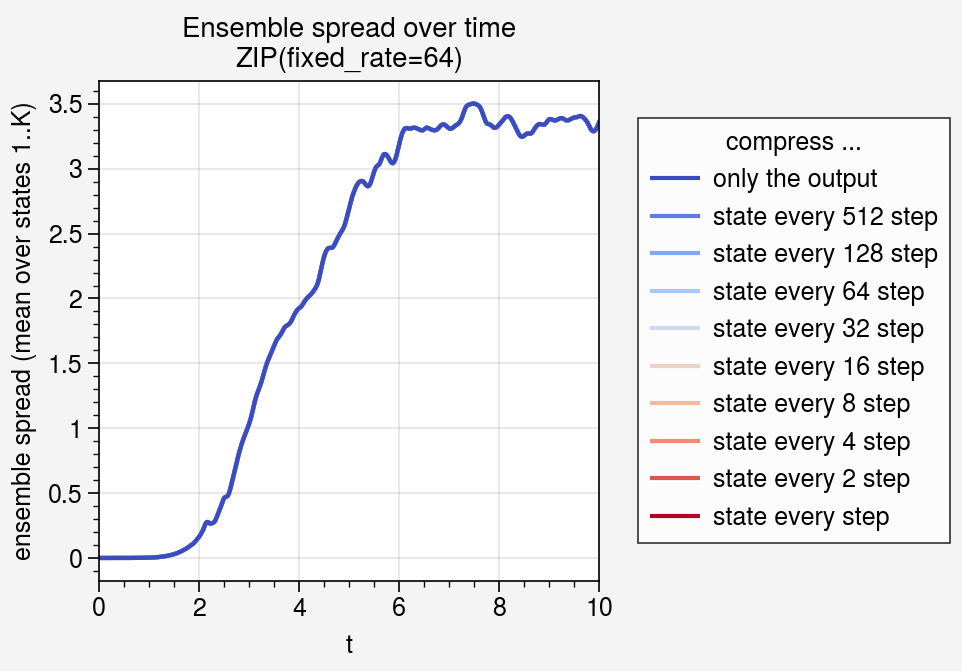

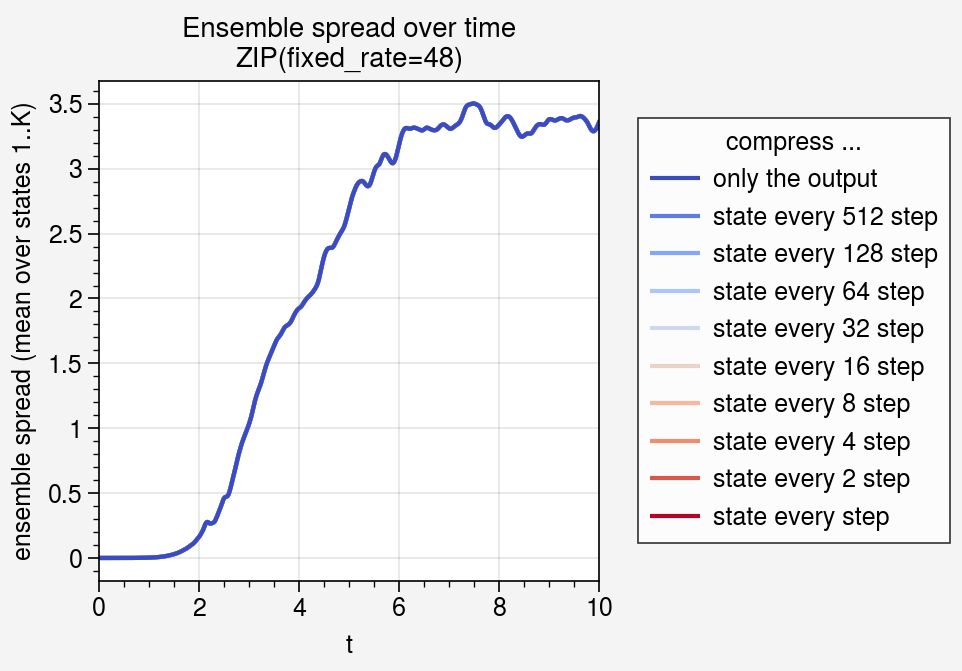

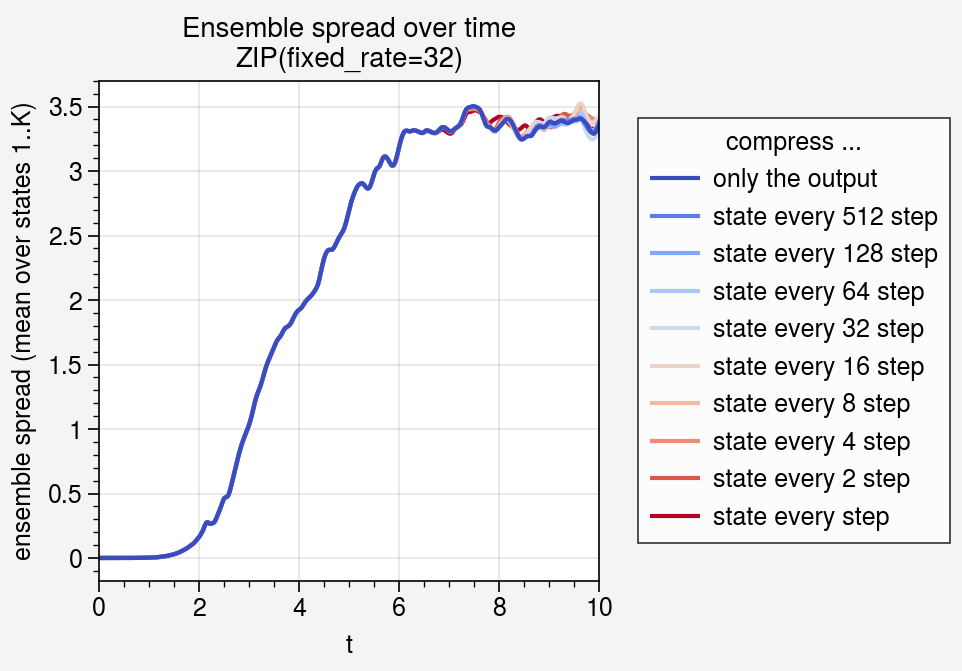

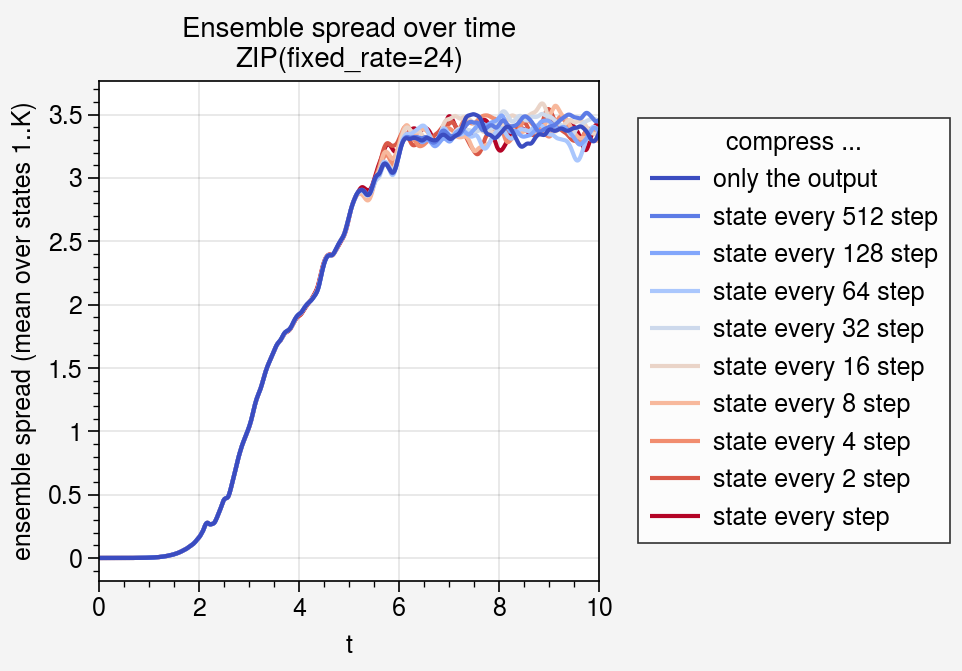

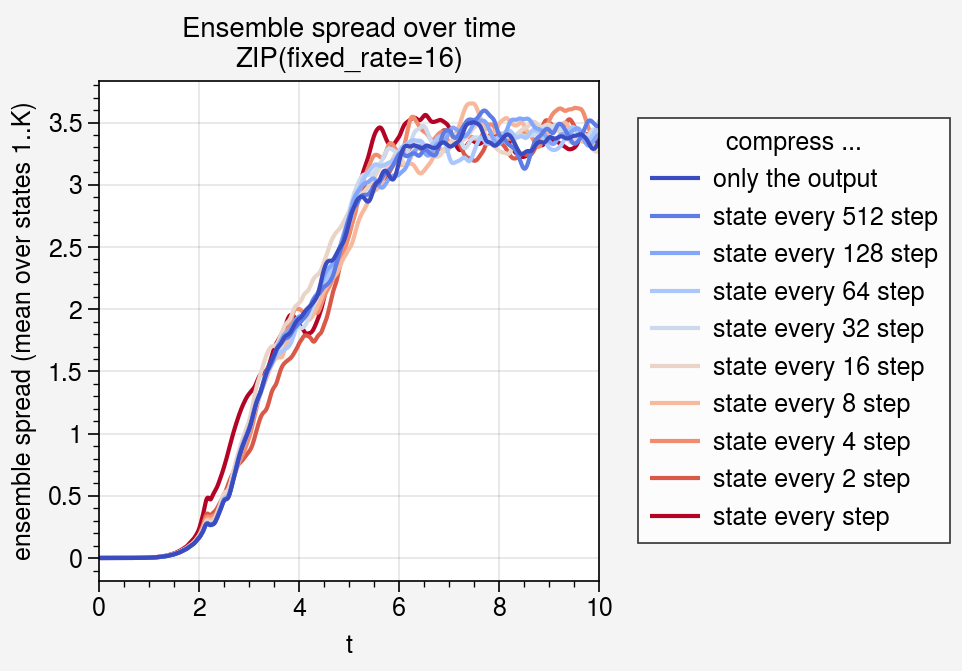

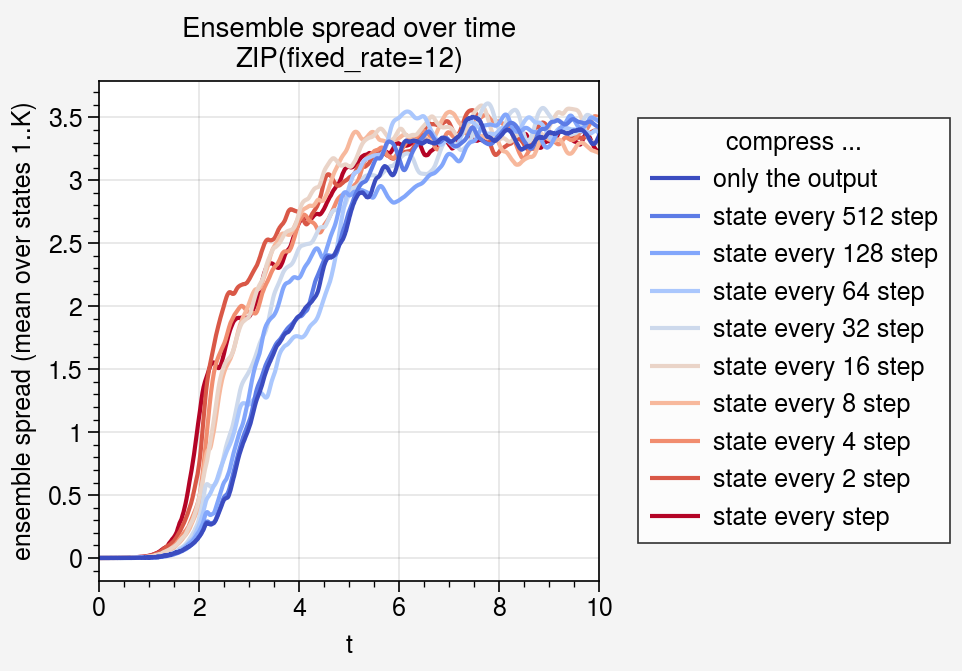

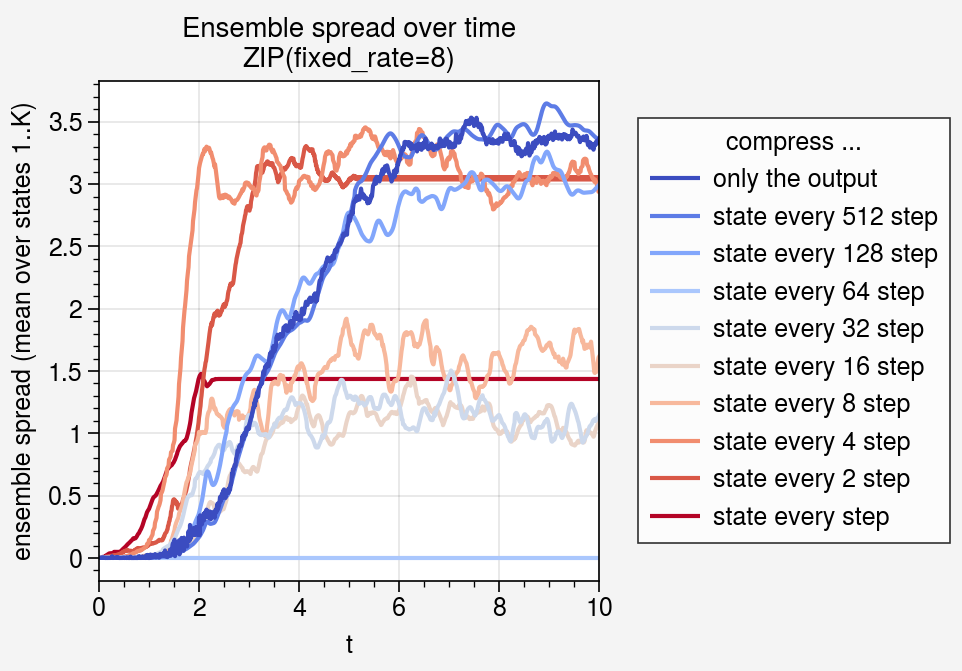

In [10]:
rates = sorted(set(c["zfp_fixed_rate"] for c in configs), reverse=True)

for rate in rates:
    rate_configs = [c for c in configs if c["zfp_fixed_rate"] == rate]
    rate_configs = sorted(
        rate_configs,
        key=lambda c: (
            c["compression_frequency"]
            if c["compression_frequency"] == 0
            else -1/c["compression_frequency"]
        ),
    )

    colors = matplotlib.pyplot.cm.coolwarm_r(np.linspace(0.0, 1.0, len(rate_configs)))
    cycle = plt.Cycle(colors=colors)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    for config in rate_configs:
        ensemble = load_model_ensemble(Path(config["output"]))

        c = config["compression_frequency"]
    
        if c < 0:
            label = "nothing"
        elif c == 0:
            label = "only the output"
        else:
            label = f"state every {c if c != 1 else 'step'}{' step' if c != 1 else ''}"
    
        ax.plot(
            np.arange(ensemble.shape[-2]) * config["dt"],
            np.mean(ensemble_spread(ensemble), axis=1),
            label=label, cycle=cycle,
        )
    
    ax.set_title(f"Ensemble spread over time\nZIP(fixed_rate={config['zfp_fixed_rate']})")
    ax.set_xlabel("$t$")
    ax.set_ylabel("ensemble spread (mean over states 1..K)")
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], title="compress ...", loc="right", ncols=1)
    
    plt.show()